https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

### Visualising high dimensional datasets

In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
# from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
# Import
path = "../data/"
file = "ratings_merged_2018.csv"
file2 = "list of movies - dataset.csv"
file3 = "users_stats.csv"
file4 = "list of movies - missing_movies_from_ml_imdbIds.csv"

ratings_merged = pd.read_csv(path+file)
movies_titles = pd.read_csv(path+file2)[["title_survey","imdbId"]]
users = list(pd.read_csv(path+file3)["userId"])
missing_movies = pd.read_csv(path+file4)

/Users/ivanlopezlobato/miniconda3/envs/code_red/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
ratings_merged

,userId,imdbId,rating,source
0,Tessa,6155172,2.0,NaN
1,brecht,6155172,4.0,NaN
2,Adam Driver,6155172,4.0,NaN
3,me,6155172,3.0,NaN
4,em,6155172,5.0,NaN
...,...,...,...,...
577553,205256,1034415,1.5,0.0
577554,215651,1034415,3.0,0.0
577555,231343,1034415,3.0,0.0
577556,137096,1517451,5.0,0.0


In [4]:
# generate the matrix
movie_features = ratings_merged.pivot_table(index="userId",
                                            columns="imdbId",
                                            values="rating").fillna(0)

y = ratings_merged["source"]

In [5]:
# calculate pca, with 3 components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(movie_features.values)
movie_features['pca-one'] = pca_result[:,0]
movie_features['pca-two'] = pca_result[:,1] 
movie_features['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.26770803 0.06499963 0.03805648]


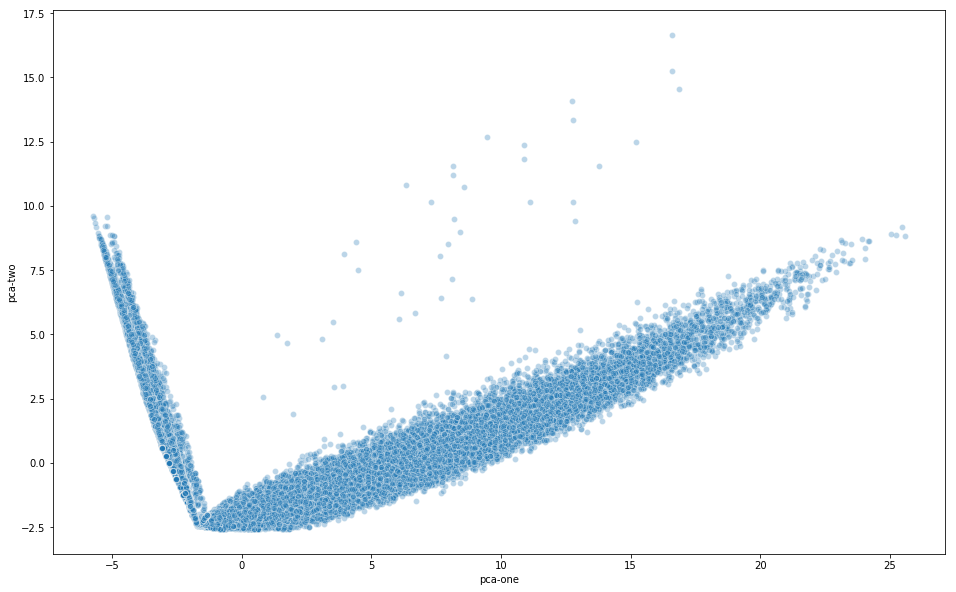

In [6]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="pca-one", 
                y="pca-two",
                palette=sns.color_palette("hls", 10),
                data=movie_features,
                legend="full",
                alpha=0.3);

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=movie_features["pca-one"], 
    ys=movie_features["pca-two"], 
    zs=movie_features["pca-three"], 
    #c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### 

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(movie_features)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [7]:
# it is possible to calculate the amount of comulative explained variation 
pca_50 = PCA(n_components=50)
pca_result_10 = pca_50.fit_transform(movie_features.values)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))


Cumulative explained variation for 50 principal components: 0.9611465322615068


In [8]:
# create a list with the cumulative explained variation increasing the PCA's
cumulative_explanation = []

# we added previously 3 pca to plot the graph, we need to remove it to calculate again the cumulative pca
movie_features_clean = movie_features.drop(columns=["pca-one","pca-two","pca-three"])

for i in range(len(movie_features_clean.T)):
    # model the pca with i components (per column)
    pca = PCA(n_components=i)
    # fiting with the movie_features
    pca_result = pca.fit_transform(movie_features_clean.values)
    cumulative_explanation.append(np.sum(pca.explained_variance_ratio_))

In [9]:
elbow_plot = pd.Series(cumulative_explanation) 
elbow_plot.head(20)

0     0.000000
1     0.267708
2     0.332708
3     0.370764
4     0.401867
5     0.430944
6     0.457960
7     0.479977
8     0.501528
9     0.522119
10    0.542338
11    0.560270
12    0.577170
13    0.594179
14    0.609353
15    0.625039
16    0.639505
17    0.653884
18    0.667940
19    0.680583
dtype: float64

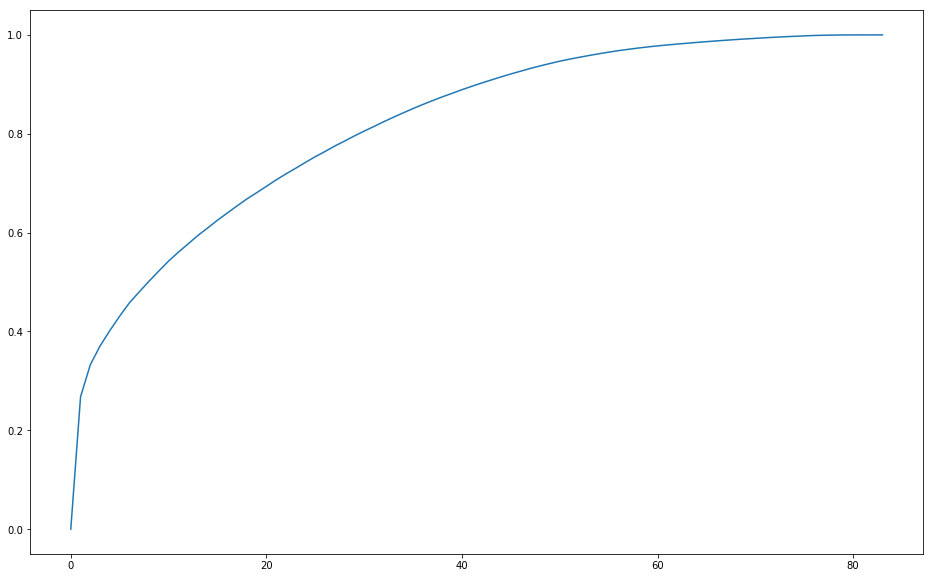

In [10]:
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=elbow_plot, style= "event", markers=True)

In [11]:
movie_features.shape

(110267, 87)

decomposing the matrix (110267 users, 99 features films) into PCA

- with the first PCA explains aprox 27% of the variation
- with 8th PCA reach 50% of the variaton explanation
- with 35 PCA explains 85% of the variation
- need to arrive to 51 PCA to get 95% of the variation 

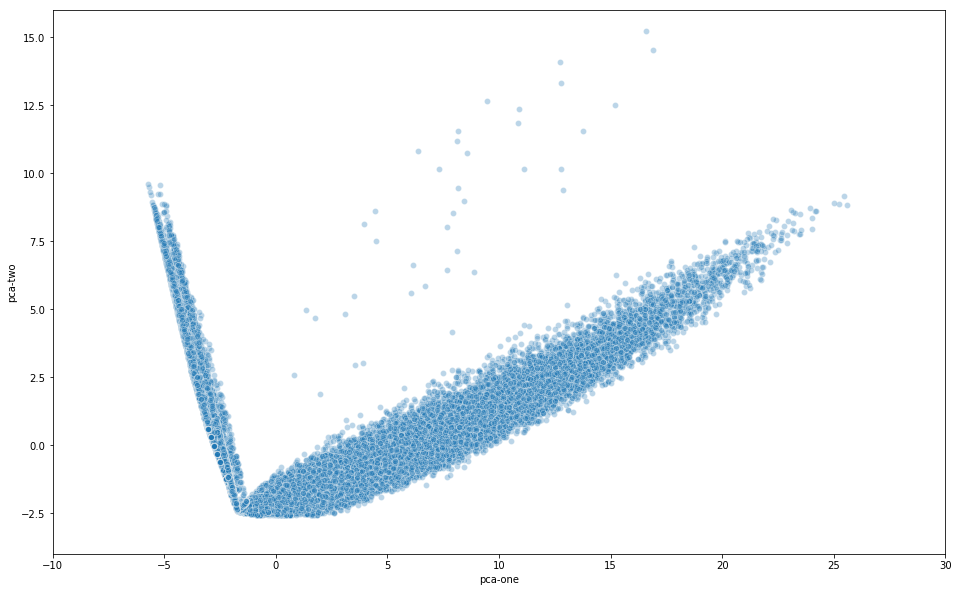

In [12]:
plt.figure(figsize=(16,10))

plt.ylim(-4,16)
plt.xlim(-10,30)
sns.scatterplot(x="pca-one", 
                y="pca-two",
                # palette=sns.color_palette("hls", 10),
                data=movie_features,
                legend="full",
                alpha=0.3);

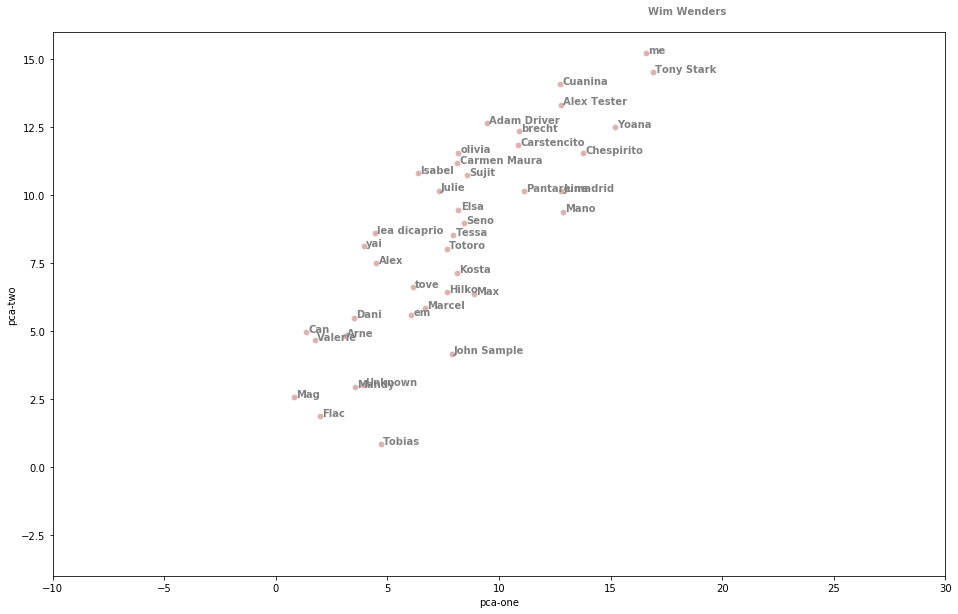

In [13]:
movie_features_users = movie_features.loc[users][["pca-one","pca-two","pca-three"]].reset_index()

plt.figure(figsize=(16,10))
plt.ylim(-4,16)
plt.xlim(-10,30)
p1 = sns.scatterplot(x="pca-one", 
                     y="pca-two",
                     color="darkred",
                     data=movie_features_users,
                     legend="full",
                     alpha=0.3);

for line in range(0,movie_features_users.shape[0]):
     p1.text(movie_features_users["pca-one"][line]+0.1,
             movie_features_users["pca-two"][line], 
             movie_features_users["userId"][line], 
             horizontalalignment='left', 
             size='medium', 
             color='grey', 
             weight='semibold')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df_iris=sns.load_dataset("iris") 

plt.figure(figsize=(20,10))
p1 = sns.scatterplot('sepal_length', # Horizontal axis
       'sepal_width', # Vertical axis
       data=df_iris, # Data source
       size = 8,
       legend=False)  

for line in range(0,df_iris.shape[0]):
     p1.text(df_iris.sepal_length[line]+0.01, df_iris.sepal_width[line], 
     df_iris.species[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

plt.title('Example Plot')
# Set x-axis label
plt.xlabel('Sepal Length')
# Set y-axis label
plt.ylabel('Sepal Width')

In [14]:
file3 = "users_stats.csv"
users = list(pd.read_csv(path+file3)["userId"])


In [15]:
movie_features_users = movie_features.loc[users][["pca-one","pca-two","pca-three"]].reset_index()

In [16]:
movie_features_users["pca-one"]

0      7.953765
1     12.873680
2      8.161987
3      8.413589
4      8.562374
5      3.921052
6     10.880227
7      1.367249
8      1.764733
9      9.470832
10     4.507457
11    16.588403
12    12.794610
13     8.889860
14     3.552947
15     4.699359
16     6.062751
17     3.516014
18    11.130371
19     6.128552
20     8.181903
21     4.424087
22    12.740427
23    12.760936
24     8.135856
25    10.873218
26     0.830483
27     3.083922
28     8.125844
29    13.783307
30     6.668820
31     1.992159
32     3.937220
33     7.662855
34     7.884124
35    16.589189
36     6.356962
37     7.298927
38    16.885337
39     7.685009
40    15.208664
Name: pca-one, dtype: float64